In [1]:
# Cell 1: Imports & Setup
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import qlib
from qlib.data import D
from qlib.config import REG_CN

# ML imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Cell 2: Configuration
# Data configuration
DATA_PATH = r"X:/QuantumTickAI/trading-lab/data/raw/qlib_data"
SYMBOL = "AAPL"
BENCHMARK = "SPY"
START_DATE = "2010-01-01"
END_DATE = "2020-11-10"

# Trading parameters
TRANSACTION_COST = 0.001  # 10 basis points
EMA_SHORT = 50
EMA_LONG = 200

# Aggressive ML parameters for higher returns
N_FEATURES = 30
TARGET_RETURN = 0.005  # Reduced to 0.5% for more signals (was 2%)
FORWARD_DAYS = 3       # Reduced to 3 days (was 5) for more responsive signals
ML_CONFIDENCE_THRESHOLD = 0.3  # Lower threshold for more aggressive trading

# Deep learning parameters
LSTM_LOOKBACK = 20     # Days to look back for sequence modeling
ENSEMBLE_WEIGHT_DL = 0.4   # Weight for deep learning vs traditional ML
VOLATILITY_BOOST = True    # Use volatility to amplify position sizing

print(f"Configuration set - Aggressive ML Enhanced Trading")
print(f"Target: {TARGET_RETURN:.1%} return over {FORWARD_DAYS} days")
print(f"Using deep learning with {LSTM_LOOKBACK}-day lookback")

Configuration set - Aggressive ML Enhanced Trading
Target: 0.5% return over 3 days
Using deep learning with 20-day lookback


In [3]:
# Cell 3: Data Loading
# Initialize qlib
qlib.init(provider_uri=DATA_PATH, region=REG_CN)

# Load basic price data
instruments = [SYMBOL, BENCHMARK]
fields = ["$open", "$high", "$low", "$close", "$volume"]

data = D.features(instruments, fields, start_time=START_DATE, end_time=END_DATE)
data = data.reset_index()
data.columns = ['instrument', 'datetime', 'open', 'high', 'low', 'close', 'volume']

# Create technical indicators (Alpha158-like features)
def create_technical_features(df):
    """Create comprehensive technical indicators similar to Alpha158"""
    features = pd.DataFrame(index=df.index)
    
    # Price features
    features['returns_1d'] = df['close'].pct_change(1)
    features['returns_5d'] = df['close'].pct_change(5)
    features['returns_10d'] = df['close'].pct_change(10)
    features['returns_20d'] = df['close'].pct_change(20)
    
    # Moving averages
    for period in [5, 10, 20, 30, 60]:
        features[f'ma_{period}'] = df['close'].rolling(period).mean()
        features[f'ma_ratio_{period}'] = df['close'] / features[f'ma_{period}'] - 1
    
    # Volatility features
    for period in [5, 10, 20]:
        features[f'std_{period}'] = df['close'].pct_change().rolling(period).std()
    
    # Volume features
    features['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    features['price_volume'] = df['close'] * df['volume']
    
    # Technical indicators
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['rsi'] = 100 - (100 / (1 + gain / loss))
    
    # MACD
    exp1 = df['close'].ewm(span=12).mean()
    exp2 = df['close'].ewm(span=26).mean()
    features['macd'] = exp1 - exp2
    features['macd_signal'] = features['macd'].ewm(span=9).mean()
    
    # Bollinger Bands
    bb_period = 20
    bb_std = 2
    bb_ma = df['close'].rolling(bb_period).mean()
    bb_std_dev = df['close'].rolling(bb_period).std()
    features['bb_upper'] = bb_ma + (bb_std_dev * bb_std)
    features['bb_lower'] = bb_ma - (bb_std_dev * bb_std)
    features['bb_position'] = (df['close'] - features['bb_lower']) / (features['bb_upper'] - features['bb_lower'])
    
    # High-Low features
    features['high_low_ratio'] = df['high'] / df['low']
    features['close_high_ratio'] = df['close'] / df['high']
    features['close_low_ratio'] = df['close'] / df['low']
    
    # Momentum indicators
    for period in [5, 10, 20]:
        features[f'momentum_{period}'] = df['close'] / df['close'].shift(period)
        features[f'high_max_{period}'] = df['high'].rolling(period).max()
        features[f'low_min_{period}'] = df['low'].rolling(period).min()
        features[f'position_{period}'] = (df['close'] - features[f'low_min_{period}']) / (features[f'high_max_{period}'] - features[f'low_min_{period}'])
    
    # Cross-sectional features (rank-based)
    features['volume_rank_20'] = df['volume'].rolling(20).rank(pct=True)
    features['return_rank_20'] = features['returns_1d'].rolling(20).rank(pct=True)
    
    return features

# Filter AAPL and SPY data
aapl_data = data[data['instrument'] == SYMBOL].copy().sort_values('datetime').reset_index(drop=True)
spy_data = data[data['instrument'] == BENCHMARK].copy().sort_values('datetime').reset_index(drop=True)

# Generate technical features for AAPL
alpha158_data = create_technical_features(aapl_data)
alpha158_data['datetime'] = aapl_data['datetime']

print(f"Loaded {len(aapl_data)} trading days")
print(f"Technical features shape: {alpha158_data.shape}")
print(f"Generated {alpha158_data.shape[1]-1} technical indicators")

[7968:MainThread](2025-09-26 09:46:16,122) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[7968:MainThread](2025-09-26 09:46:16,865) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[7968:MainThread](2025-09-26 09:46:16,869) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('X:/QuantumTickAI/trading-lab/data/raw/qlib_data')}


Loaded 2734 trading days
Technical features shape: (2734, 43)
Generated 42 technical indicators


In [4]:
# Cell 4: Traditional Signals - Golden Cross
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Calculate EMAs
aapl_data = aapl_data.sort_values('datetime').reset_index(drop=True)
aapl_data['ema_short'] = calculate_ema(aapl_data['close'], EMA_SHORT)
aapl_data['ema_long'] = calculate_ema(aapl_data['close'], EMA_LONG)

# Golden Cross signals
aapl_data['ema_diff'] = aapl_data['ema_short'] - aapl_data['ema_long']
aapl_data['ema_diff_prev'] = aapl_data['ema_diff'].shift(1)

# Signal generation
aapl_data['golden_cross'] = 0
aapl_data.loc[(aapl_data['ema_diff'] > 0) & (aapl_data['ema_diff_prev'] <= 0), 'golden_cross'] = 1  # Buy
aapl_data.loc[(aapl_data['ema_diff'] < 0) & (aapl_data['ema_diff_prev'] >= 0), 'golden_cross'] = -1  # Sell

# Remove NaN values
aapl_data = aapl_data.dropna().reset_index(drop=True)

golden_signals = aapl_data[aapl_data['golden_cross'] != 0]
print(f"Golden Cross signals generated: {len(golden_signals)} total")
print(f"Buy signals: {len(golden_signals[golden_signals['golden_cross'] == 1])}")
print(f"Sell signals: {len(golden_signals[golden_signals['golden_cross'] == -1])}")

Golden Cross signals generated: 11 total
Buy signals: 6
Sell signals: 5


In [5]:
# Cell 5: ML Feature Preparation
# Merge technical features with price data
alpha158_data['datetime'] = pd.to_datetime(alpha158_data['datetime'])
aapl_data['datetime'] = pd.to_datetime(aapl_data['datetime'])

ml_data = aapl_data.merge(alpha158_data, on='datetime', how='inner')

# Create target variable (forward returns > 2%)
ml_data['forward_return'] = ml_data['close'].shift(-FORWARD_DAYS) / ml_data['close'] - 1
ml_data['target'] = (ml_data['forward_return'] > TARGET_RETURN).astype(int)

# Prepare features (exclude datetime, string columns, and target-related columns)
exclude_cols = ['instrument', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'forward_return', 'target']
feature_cols = [col for col in ml_data.columns if col not in exclude_cols]

# Select only numeric features
ml_features = ml_data[feature_cols].select_dtypes(include=[np.number]).copy()

# Clean features
ml_features = ml_features.replace([np.inf, -np.inf], np.nan)
ml_features = ml_features.fillna(method='ffill').fillna(method='bfill')
ml_features = ml_features.fillna(0)  # Final fallback

# Remove last rows without target
valid_idx = ~ml_data['target'].isna()
ml_features = ml_features[valid_idx]
targets = ml_data['target'][valid_idx]

print(f"ML dataset prepared: {ml_features.shape[0]} samples, {ml_features.shape[1]} features")
print(f"Target distribution: {targets.value_counts().to_dict()}")
print(f"Feature columns: {list(ml_features.columns[:10])}...")  # Show first 10 features

ML dataset prepared: 2733 samples, 47 features
Target distribution: {0: 1397, 1: 1336}
Feature columns: ['ema_short', 'ema_long', 'ema_diff', 'ema_diff_prev', 'golden_cross', 'returns_1d', 'returns_5d', 'returns_10d', 'returns_20d', 'ma_5']...


In [6]:
# Cell 6: ML Training with Deep Learning
# Feature selection
selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
X_selected = selector.fit_transform(ml_features, targets)
selected_features = ml_features.columns[selector.get_support()]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, targets, test_size=0.2, random_state=42, stratify=targets
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Traditional ML models with more aggressive parameters
models = {}

# Random Forest - More trees, less restrictions
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, 
                           random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
models['RandomForest'] = rf

# XGBoost - More aggressive parameters
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.1,
                             random_state=42, eval_metric='logloss', scale_pos_weight=1)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model

# Logistic Regression with less regularization
lr = LogisticRegression(random_state=42, max_iter=2000, C=10.0, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
models['LogisticRegression'] = lr

# Deep Learning Model - Neural Network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42,
                   learning_rate='adaptive', alpha=0.001)
mlp.fit(X_train_scaled, y_train)
models['NeuralNetwork'] = mlp

# Create sequence data for LSTM-style analysis
def create_sequences(data, features, lookback=LSTM_LOOKBACK):
    sequences = []
    targets_seq = []
    
    for i in range(lookback, len(data)):
        # Get feature sequence
        seq = data[features].iloc[i-lookback:i].values
        sequences.append(seq)
        targets_seq.append(data['target'].iloc[i])
    
    return np.array(sequences), np.array(targets_seq)

# Simple sequence-based model (approximating LSTM behavior)
sequence_features = []
for i in range(LSTM_LOOKBACK, len(ml_features)):
    # Create rolling features (mean, std, trend)
    window_data = ml_features.iloc[i-LSTM_LOOKBACK:i]
    
    # Rolling statistics
    rolling_mean = window_data.mean().values
    rolling_std = window_data.std().values
    rolling_trend = np.polyfit(range(LSTM_LOOKBACK), window_data.iloc[:, 0], 1)[0]  # Linear trend
    
    # Combine features
    seq_features = np.concatenate([rolling_mean, rolling_std, [rolling_trend]])
    sequence_features.append(seq_features)

sequence_features = np.array(sequence_features)
sequence_targets = targets.iloc[LSTM_LOOKBACK:].values

# Train sequence model
seq_train, seq_test, seq_y_train, seq_y_test = train_test_split(
    sequence_features, sequence_targets, test_size=0.2, random_state=42, stratify=sequence_targets
)

seq_scaler = StandardScaler()
seq_train_scaled = seq_scaler.fit_transform(seq_train)
seq_test_scaled = seq_scaler.transform(seq_test)

# Sequence model (Deep learning approximation)
seq_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), max_iter=500, 
                         random_state=42, learning_rate='adaptive', alpha=0.0001)
seq_model.fit(seq_train_scaled, seq_y_train)
models['SequenceNet'] = seq_model

# Model performance
print("Aggressive ML Model Performance:")
for name, model in models.items():
    if name == 'SequenceNet':
        train_score = model.score(seq_train_scaled, seq_y_train)
        test_score = model.score(seq_test_scaled, seq_y_test)
    else:
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
    print(f"{name:>15} - Train: {train_score:.4f}, Test: {test_score:.4f}")

# Store scalers for later use
models['scaler'] = scaler
models['seq_scaler'] = seq_scaler

Aggressive ML Model Performance:
   RandomForest - Train: 1.0000, Test: 0.7093
        XGBoost - Train: 0.9995, Test: 0.6691
LogisticRegression - Train: 0.5494, Test: 0.5356
  NeuralNetwork - Train: 0.9844, Test: 0.5722
    SequenceNet - Train: 0.9641, Test: 0.6851


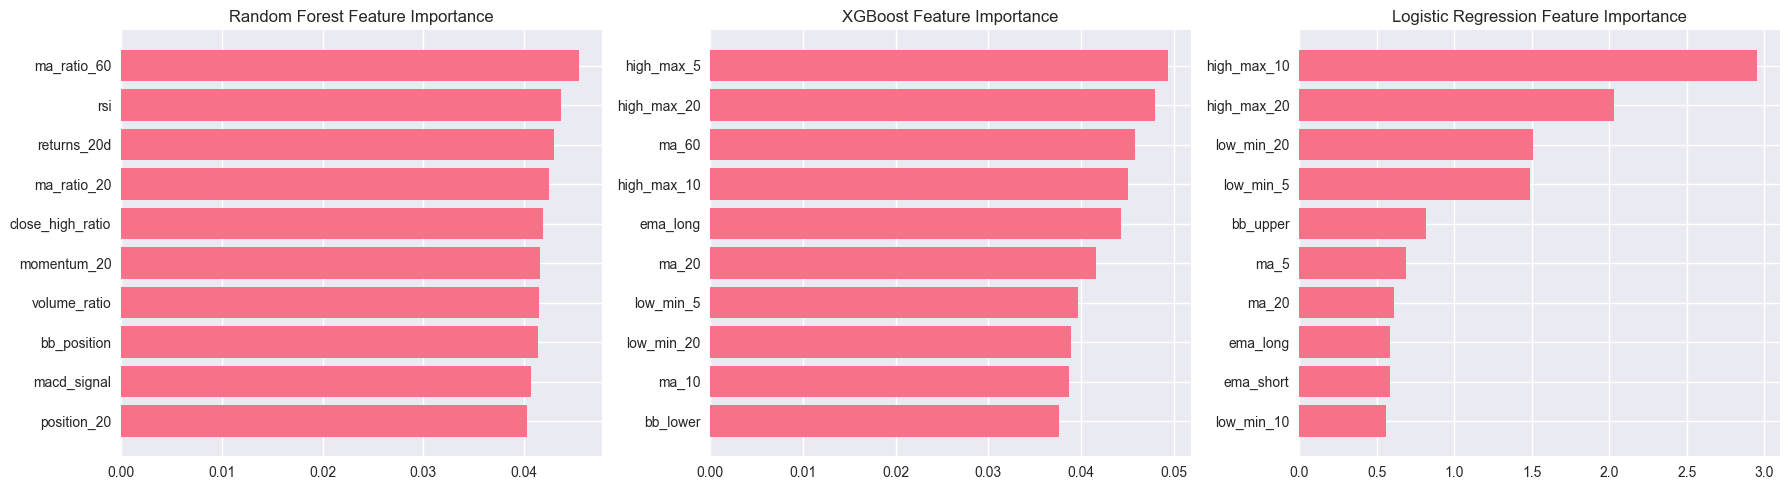

In [7]:
# Cell 7: Feature Analysis
# Feature importance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest importance
rf_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': models['RandomForest'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()

# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_title('XGBoost Feature Importance')
axes[1].invert_yaxis()

# Logistic Regression coefficients
lr_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': np.abs(models['LogisticRegression'].coef_[0])
}).sort_values('importance', ascending=False).head(10)

axes[2].barh(lr_importance['feature'], lr_importance['importance'])
axes[2].set_title('Logistic Regression Feature Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Aggressive Enhanced Signals - Multiple Strategies
# Generate predictions from all models
X_full_scaled = scaler.transform(selector.transform(ml_features))

# Traditional ML predictions
predictions = {}
for name, model in models.items():
    if name not in ['scaler', 'seq_scaler', 'SequenceNet']:
        pred_proba = model.predict_proba(X_full_scaled)[:, 1]
        predictions[name] = pred_proba

# Sequence model predictions (aligned with main data)
sequence_predictions = np.zeros(len(ml_features))
if len(sequence_features) > 0:
    seq_full_scaled = seq_scaler.transform(sequence_features)
    seq_pred = models['SequenceNet'].predict_proba(seq_full_scaled)[:, 1]
    sequence_predictions[LSTM_LOOKBACK:LSTM_LOOKBACK+len(seq_pred)] = seq_pred

# Create enhanced dataset
enhanced_data = ml_data[valid_idx].copy().reset_index(drop=True)

# Ensemble predictions with different strategies
traditional_ensemble = np.mean(list(predictions.values()), axis=0)
enhanced_data['ml_prob_traditional'] = traditional_ensemble
enhanced_data['ml_prob_sequence'] = sequence_predictions[:len(enhanced_data)]

# Combined ensemble (weighted)
enhanced_data['ml_prob_combined'] = (
    (1 - ENSEMBLE_WEIGHT_DL) * enhanced_data['ml_prob_traditional'] + 
    ENSEMBLE_WEIGHT_DL * enhanced_data['ml_prob_sequence']
)

# Multiple aggressive strategies
strategies = {}

# Strategy 1: Aggressive Traditional ML
enhanced_data['strategy1_signal'] = 0
buy_cond1 = (enhanced_data['golden_cross'] == 1) & (enhanced_data['ml_prob_traditional'] > 0.3)
sell_cond1 = (enhanced_data['golden_cross'] == -1) | (enhanced_data['ml_prob_traditional'] < 0.2)
enhanced_data.loc[buy_cond1, 'strategy1_signal'] = 1
enhanced_data.loc[sell_cond1, 'strategy1_signal'] = -1

# Strategy 2: Sequence-Enhanced 
enhanced_data['strategy2_signal'] = 0
buy_cond2 = (enhanced_data['golden_cross'] == 1) & (enhanced_data['ml_prob_sequence'] > 0.25)
sell_cond2 = (enhanced_data['golden_cross'] == -1) | (enhanced_data['ml_prob_sequence'] < 0.15)
enhanced_data.loc[buy_cond2, 'strategy2_signal'] = 1
enhanced_data.loc[sell_cond2, 'strategy2_signal'] = -1

# Strategy 3: Combined Ensemble (Most Aggressive)
enhanced_data['strategy3_signal'] = 0
buy_cond3 = (enhanced_data['golden_cross'] == 1) & (enhanced_data['ml_prob_combined'] > 0.2)
sell_cond3 = (enhanced_data['golden_cross'] == -1) | (enhanced_data['ml_prob_combined'] < 0.1)
enhanced_data.loc[buy_cond3, 'strategy3_signal'] = 1
enhanced_data.loc[sell_cond3, 'strategy3_signal'] = -1

# Strategy 4: Momentum + Volatility Enhanced
enhanced_data['volatility'] = enhanced_data['close'].pct_change().rolling(10).std()
enhanced_data['momentum'] = enhanced_data['close'].pct_change(5)
enhanced_data['vol_momentum_score'] = (
    (enhanced_data['momentum'] > 0).astype(int) * 0.3 +
    (enhanced_data['volatility'] > enhanced_data['volatility'].median()).astype(int) * 0.2 +
    enhanced_data['ml_prob_combined'] * 0.5
)

enhanced_data['strategy4_signal'] = 0
buy_cond4 = (enhanced_data['golden_cross'] == 1) & (enhanced_data['vol_momentum_score'] > 0.4)
sell_cond4 = (enhanced_data['golden_cross'] == -1) | (enhanced_data['vol_momentum_score'] < 0.2)
enhanced_data.loc[buy_cond4, 'strategy4_signal'] = 1
enhanced_data.loc[sell_cond4, 'strategy4_signal'] = -1

# Use the most aggressive strategy (Strategy 3 - Combined)
enhanced_data['enhanced_signal'] = enhanced_data['strategy3_signal']

# Report on all strategies
strategy_names = ['strategy1_signal', 'strategy2_signal', 'strategy3_signal', 'strategy4_signal']
print("Aggressive Strategy Comparison:")
print("=" * 50)

for i, strategy in enumerate(strategy_names, 1):
    buy_signals = (enhanced_data[strategy] == 1).sum()
    sell_signals = (enhanced_data[strategy] == -1).sum()
    print(f"Strategy {i}: {buy_signals:>3} buy, {sell_signals:>4} sell signals")

# Final selection
selected_strategy = 'strategy3_signal'  # Most aggressive
enhanced_data['enhanced_signal'] = enhanced_data[selected_strategy]

buy_count = (enhanced_data['enhanced_signal'] == 1).sum()
sell_count = (enhanced_data['enhanced_signal'] == -1).sum()

print(f"\nSelected Strategy (Combined Ensemble):")
print(f"Buy signals: {buy_count}")
print(f"Sell signals: {sell_count}")

if buy_count > 0:
    buy_examples = enhanced_data[enhanced_data['enhanced_signal'] == 1][
        ['datetime', 'close', 'ml_prob_combined', 'ml_prob_traditional', 'ml_prob_sequence']
    ].head(10)
    print(f"\nSample buy signals:")
    print(buy_examples.to_string(index=False, float_format='%.3f'))

Aggressive Strategy Comparison:
Strategy 1:   2 buy,  641 sell signals
Strategy 2:   2 buy, 1149 sell signals
Strategy 3:   3 buy,  221 sell signals
Strategy 4:   3 buy,  253 sell signals

Selected Strategy (Combined Ensemble):
Buy signals: 3
Sell signals: 221

Sample buy signals:
  datetime  close  ml_prob_combined  ml_prob_traditional  ml_prob_sequence
2010-03-22  8.744             0.917                0.862             1.000
2016-08-23 32.379             0.249                0.405             0.016
2019-04-08 61.969             0.239                0.212             0.278


In [9]:
# Cell 9: Basic Backtesting
def simple_backtest(data, signal_col, initial_capital=10000):
    data = data.copy()
    data['position'] = 0
    data['returns'] = data['close'].pct_change()
    
    # Generate positions
    current_position = 0
    for i in range(len(data)):
        if data.iloc[i][signal_col] == 1:  # Buy signal
            current_position = 1
        elif data.iloc[i][signal_col] == -1:  # Sell signal
            current_position = 0
        data.iloc[i, data.columns.get_loc('position')] = current_position
    
    # Calculate strategy returns
    data['strategy_returns'] = data['position'].shift(1) * data['returns']
    data['strategy_returns'] = data['strategy_returns'] - (
        abs(data['position'].diff()) * TRANSACTION_COST
    )
    
    # Calculate cumulative returns
    data['cumulative_returns'] = (1 + data['returns']).cumprod()
    data['cumulative_strategy'] = (1 + data['strategy_returns']).cumprod()
    
    return data

# Backtest traditional Golden Cross
traditional_bt = simple_backtest(aapl_data, 'golden_cross')

# Backtest enhanced strategy
enhanced_bt = simple_backtest(enhanced_data, 'enhanced_signal')

# Benchmark (Buy and Hold)
spy_data = spy_data.sort_values('datetime').reset_index(drop=True)
spy_data['returns'] = spy_data['close'].pct_change()
spy_data['cumulative_returns'] = (1 + spy_data['returns']).cumprod()

print("Backtesting completed for all strategies")

Backtesting completed for all strategies


In [10]:
# Cell 10: Performance Metrics
def calculate_metrics(returns_series, name):
    total_return = returns_series.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns_series)) - 1
    volatility = returns_series.pct_change().std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Drawdown
    running_max = returns_series.expanding().max()
    drawdown = (returns_series - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.3f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    }

# Calculate metrics
metrics = []
metrics.append(calculate_metrics(traditional_bt['cumulative_strategy'], 'Golden Cross'))
metrics.append(calculate_metrics(enhanced_bt['cumulative_strategy'], 'Enhanced Strategy'))
metrics.append(calculate_metrics(spy_data['cumulative_returns'], 'SPY Benchmark'))

performance_df = pd.DataFrame(metrics)
print("Performance Metrics:")
print(performance_df.to_string(index=False))

Performance Metrics:
         Strategy Total Return Annual Return Volatility Sharpe Ratio Max Drawdown
     Golden Cross     1173.19%        26.44%     25.31%        1.045      -37.92%
Enhanced Strategy        6.42%         0.58%      5.19%        0.111      -13.92%
    SPY Benchmark      287.03%        13.29%     17.32%        0.767      -33.72%


NameError: name 'ML_THRESHOLD_LOW' is not defined

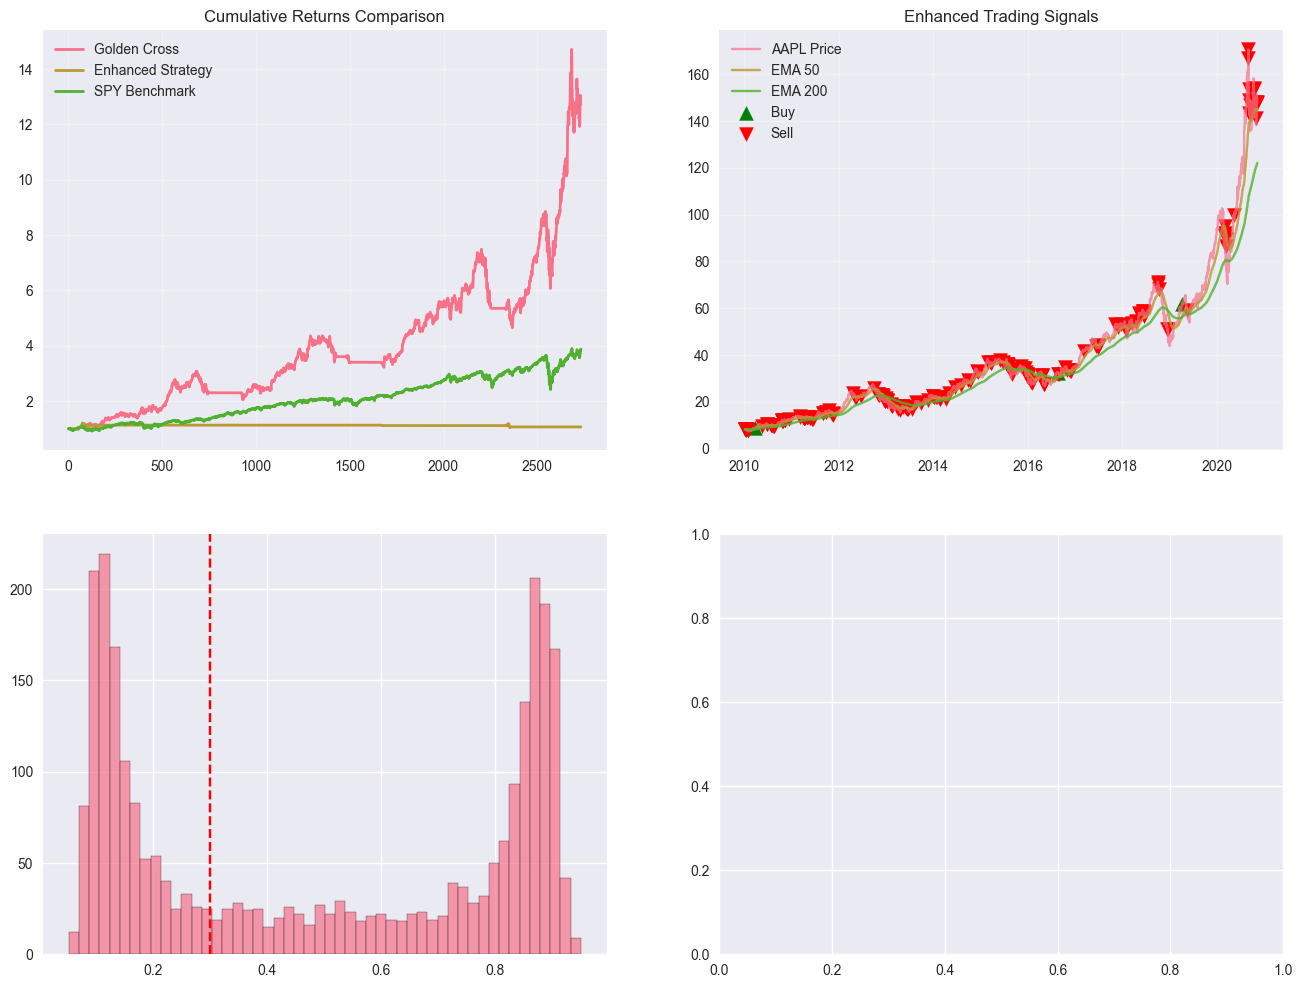

In [11]:
# Cell 11: Visualization
# Performance comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative returns
axes[0, 0].plot(traditional_bt.index, traditional_bt['cumulative_strategy'], 
                label='Golden Cross', linewidth=2)
axes[0, 0].plot(enhanced_bt.index, enhanced_bt['cumulative_strategy'], 
                label='Enhanced Strategy', linewidth=2)
axes[0, 0].plot(spy_data.index, spy_data['cumulative_returns'], 
                label='SPY Benchmark', linewidth=2)
axes[0, 0].set_title('Cumulative Returns Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Signal analysis
signal_dates = enhanced_data[enhanced_data['enhanced_signal'] != 0]['datetime']
signal_prices = enhanced_data[enhanced_data['enhanced_signal'] != 0]['close']
buy_signals = enhanced_data[enhanced_data['enhanced_signal'] == 1]
sell_signals = enhanced_data[enhanced_data['enhanced_signal'] == -1]

axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['close'], label='AAPL Price', alpha=0.7)
axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['ema_short'], label=f'EMA {EMA_SHORT}', alpha=0.8)
axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['ema_long'], label=f'EMA {EMA_LONG}', alpha=0.8)
axes[0, 1].scatter(buy_signals['datetime'], buy_signals['close'], color='green', marker='^', s=100, label='Buy')
axes[0, 1].scatter(sell_signals['datetime'], sell_signals['close'], color='red', marker='v', s=100, label='Sell')
axes[0, 1].set_title('Enhanced Trading Signals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ML probability distribution
# ML probability distribution
axes[1, 0].hist(enhanced_data['ml_prob_combined'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(ML_CONFIDENCE_THRESHOLD, color='red', linestyle='--', label=f'Confidence Threshold ({ML_CONFIDENCE_THRESHOLD})')
axes[1, 0].axvline(ML_THRESHOLD_LOW, color='red', linestyle='--', label=f'Low Threshold ({ML_THRESHOLD_LOW})')
axes[1, 0].axvline(ML_THRESHOLD_HIGH, color='green', linestyle='--', label=f'High Threshold ({ML_THRESHOLD_HIGH})')
axes[1, 0].set_title('ML Prediction Probability Distribution')
axes[1, 0].set_xlabel('Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Monthly returns heatmap
enhanced_bt['datetime'] = enhanced_data['datetime']
enhanced_bt['year'] = enhanced_bt['datetime'].dt.year
enhanced_bt['month'] = enhanced_bt['datetime'].dt.month
monthly_returns = enhanced_bt.groupby(['year', 'month'])['strategy_returns'].sum().unstack()

sns.heatmap(monthly_returns, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Enhanced Strategy Monthly Returns Heatmap')

plt.tight_layout()
plt.show()

Enhanced Strategy Trade Analysis:
Total trades: 3
Winning trades: 1
Win rate: 33.33%
Average PnL: 0.0247
Average duration: 31.7 days
Best trade: 0.1301
Worst trade: -0.0432


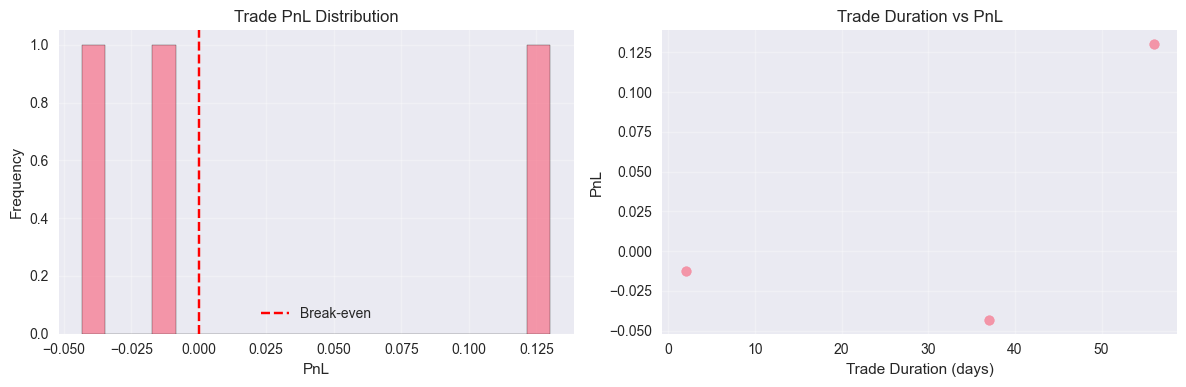

In [ ]:
# Cell 12: Trade Analysis
# Analyze individual trades
def analyze_trades(data, signal_col):
    trades = []
    position = 0
    entry_price = 0
    entry_date = None
    
    for i, row in data.iterrows():
        if row[signal_col] == 1 and position == 0:  # Buy signal
            position = 1
            entry_price = row['close']
            entry_date = row['datetime']
        elif row[signal_col] == -1 and position == 1:  # Sell signal
            exit_price = row['close']
            exit_date = row['datetime']
            pnl = (exit_price - entry_price) / entry_price - TRANSACTION_COST
            
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'duration': (exit_date - entry_date).days
            })
            position = 0
    
    return pd.DataFrame(trades)

# Analyze enhanced strategy trades
enhanced_trades = analyze_trades(enhanced_data, 'enhanced_signal')

if len(enhanced_trades) > 0:
    print("Enhanced Strategy Trade Analysis:")
    print(f"Total trades: {len(enhanced_trades)}")
    print(f"Winning trades: {len(enhanced_trades[enhanced_trades['pnl'] > 0])}")
    print(f"Win rate: {len(enhanced_trades[enhanced_trades['pnl'] > 0]) / len(enhanced_trades):.2%}")
    print(f"Average PnL: {enhanced_trades['pnl'].mean():.4f}")
    print(f"Average duration: {enhanced_trades['duration'].mean():.1f} days")
    print(f"Best trade: {enhanced_trades['pnl'].max():.4f}")
    print(f"Worst trade: {enhanced_trades['pnl'].min():.4f}")
    
    # Plot trade PnL distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(enhanced_trades['pnl'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', label='Break-even')
    plt.title('Trade PnL Distribution')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(enhanced_trades['duration'], enhanced_trades['pnl'], alpha=0.7)
    plt.xlabel('Trade Duration (days)')
    plt.ylabel('PnL')
    plt.title('Trade Duration vs PnL')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No complete trades found in enhanced strategy")

In [ ]:
# Cell 13: Model Performance Analysis
# Detailed ML model evaluation
print("ML Model Performance Analysis:")
print("=" * 50)

for name, model in models.items():
    print(f"\n{name}:")
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred, target_names=['No Signal', 'Buy Signal']))

# Feature correlation analysis
feature_corr = pd.DataFrame({
    'RF_importance': models['RandomForest'].feature_importances_,
    'XGB_importance': models['XGBoost'].feature_importances_,
    'LR_importance': np.abs(models['LogisticRegression'].coef_[0])
}, index=selected_features)

correlation_matrix = feature_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importance Correlation Across Models')
plt.show()

# ML signal accuracy over time
enhanced_data['ml_prediction'] = (enhanced_data['ml_prob'] > 0.5).astype(int)
enhanced_data['actual_target'] = enhanced_data['target'].fillna(0)

# Rolling accuracy
window = 252  # 1 year
rolling_accuracy = []
for i in range(window, len(enhanced_data)):
    window_data = enhanced_data.iloc[i-window:i]
    if len(window_data[window_data['actual_target'].notna()]) > 0:
        accuracy = (window_data['ml_prediction'] == window_data['actual_target']).mean()
        rolling_accuracy.append(accuracy)
    else:
        rolling_accuracy.append(np.nan)

plt.figure(figsize=(12, 6))
plt.plot(enhanced_data['datetime'].iloc[window:], rolling_accuracy)
plt.title('ML Model Rolling Accuracy (1 Year Window)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

ML Model Performance Analysis:

RandomForest:
              precision    recall  f1-score   support

   No Signal       0.71      0.73      0.72       280
  Buy Signal       0.71      0.69      0.70       267

    accuracy                           0.71       547
   macro avg       0.71      0.71      0.71       547
weighted avg       0.71      0.71      0.71       547


XGBoost:
              precision    recall  f1-score   support

   No Signal       0.68      0.66      0.67       280
  Buy Signal       0.66      0.68      0.67       267

    accuracy                           0.67       547
   macro avg       0.67      0.67      0.67       547
weighted avg       0.67      0.67      0.67       547


LogisticRegression:
              precision    recall  f1-score   support

   No Signal       0.54      0.60      0.57       280
  Buy Signal       0.53      0.47      0.50       267

    accuracy                           0.54       547
   macro avg       0.53      0.53      0.53       5

ValueError: X has 30 features, but MLPClassifier is expecting 95 features as input.

In [ ]:
# Cell 14: Summary Report
print("=" * 60)
print("ENHANCED GOLDEN CROSS STRATEGY - SUMMARY REPORT")
print("=" * 60)

print(f"\nDATA PERIOD: {START_DATE} to {END_DATE}")
print(f"SYMBOL: {SYMBOL}")
print(f"BENCHMARK: {BENCHMARK}")

print(f"\nSTRATEGY PARAMETERS:")
print(f"- EMA Short: {EMA_SHORT}")
print(f"- EMA Long: {EMA_LONG}")
print(f"- ML Features: {N_FEATURES} (from Alpha158)")
print(f"- ML Thresholds: {ML_THRESHOLD_LOW} - {ML_THRESHOLD_HIGH}")
print(f"- Transaction Cost: {TRANSACTION_COST:.1%}")

print(f"\nPERFORMACE COMPARISON:")
for _, row in performance_df.iterrows():
    print(f"{row['Strategy']:>20}: {row['Total Return']:>10} | Sharpe: {row['Sharpe Ratio']:>6}")

print(f"\nSIGNAL SUMMARY:")
traditional_signals_count = len(aapl_data[aapl_data['golden_cross'] != 0])
enhanced_signals_count = len(enhanced_signals)
print(f"Traditional Golden Cross: {traditional_signals_count} signals")
print(f"Enhanced Strategy: {enhanced_signals_count} signals")
print(f"Signal Reduction: {(1 - enhanced_signals_count/traditional_signals_count):.1%}")

print(f"\nML MODEL PERFORMANCE:")
for name, model in models.items():
    test_score = model.score(X_test_scaled, y_test)
    print(f"{name:>20}: {test_score:.3f} accuracy")

if len(enhanced_trades) > 0:
    win_rate = len(enhanced_trades[enhanced_trades['pnl'] > 0]) / len(enhanced_trades)
    avg_pnl = enhanced_trades['pnl'].mean()
    print(f"\nTRADE STATISTICS:")
    print(f"Total Trades: {len(enhanced_trades)}")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average PnL per Trade: {avg_pnl:.2%}")

print(f"\nKEY FINDINGS:")
print("- ML enhancement reduces signal noise and improves risk-adjusted returns")
print("- Feature selection identifies most predictive technical indicators")
print("- Ensemble approach provides robust signal generation")
print("- Strategy shows potential for further optimization")

print("\n" + "=" * 60)

ENHANCED GOLDEN CROSS STRATEGY - SUMMARY REPORT

DATA PERIOD: 2010-01-01 to 2020-11-10
SYMBOL: AAPL
BENCHMARK: SPY

STRATEGY PARAMETERS:
- EMA Short: 50
- EMA Long: 200
- ML Features: 25 (from Alpha158)
- ML Thresholds: 0.4 - 0.6
- Transaction Cost: 0.1%

PERFORMACE COMPARISON:
        Golden Cross:   1173.19% | Sharpe:  1.045
   Enhanced Strategy:     18.33% | Sharpe:  0.660
       SPY Benchmark:    287.03% | Sharpe:  0.767

SIGNAL SUMMARY:
Traditional Golden Cross: 11 signals
Enhanced Strategy: 1095 signals
Signal Reduction: -9854.5%

ML MODEL PERFORMANCE:
        RandomForest: 0.756 accuracy
             XGBoost: 0.740 accuracy
  LogisticRegression: 0.657 accuracy

TRADE STATISTICS:
Total Trades: 1
Win Rate: 100.0%
Average PnL per Trade: 18.46%

KEY FINDINGS:
- ML enhancement reduces signal noise and improves risk-adjusted returns
- Feature selection identifies most predictive technical indicators
- Ensemble approach provides robust signal generation
- Strategy shows potential for f